# **Update**
- Ran 50 runs of automodel, found best model at run 2 lol
- did not set seed for this but doesnt really matter
- have a model that found 240/250 bombs and 991/1000 non bombs correctly classified
- this model should always return these values ^ if reinferenced on test data
- try the model i designed on this train/test split for comparison
- go explore which files this new one got wrong
- use the saved history to plot the auprc curve/other metrics
- tidy up dirs in google drive
- start writing a script to inference on more data (maybe start with one moth I know bombs for)


**Old comments:**

What this script does:
- find the data
- shuffle the data
- split it into training/val and test data
- calc mel specs. Use Mel specs as these emphasise lower freq sounds (which the bombs are). Can also use MFCC's but these are meant to overcome amplitude diffs for e.g speech or music, however, I think these are useful for bombs so keep as mel-spec
- train CNN
- inference on test data


to do:
- get proper cross val results (after hyperparam opt?)
- save nodel
- move inference to new script

optional 
- hyperparam optimisation
- augmentation
- add wandb callback




# **Model ID and training**

This script uses autokeras to find the best model architecture and outputs a saved version of this model. The performance of this model can then be assessed in the next script 'Evaluating performance'.


# Installs and imports

1. Downgrade tensorflow to revent bugs when using the autokeras package.See here: https://stackoverflow.com/questions/73770146/warningtensorflowusing-a-while-loop-for-converting-cause-there-is-no-registere
2. Restart the runtime (you do not need to run this cell again)
3. Install autokeras
4. Connect Google Drive
5. Set paths to your input and output directories
6. Import all other packages

In [ ]:
# Downgrade tensorflow, run this cell, restart the runtime then no need to run this cell again
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.4/498.4 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 21.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

In [ ]:
# check the downgraded version of tf is installed, should print 2.8.3
import tensorflow as tf
print(tf.__version__)

2.8.3


In [ ]:
# Connect GDrive - click yes to all requests
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install autokeras
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# set paths to where audio is saved
train_dir = "/content/drive/MyDrive/bombs/data/final_dataset/train_data/" #make sure ends in '/'
test_dir = "/content/drive/MyDrive/bombs/data/final_dataset/test_data/"
pickle_file_dir = "/content/drive/MyDrive/bombs/data/final_dataset/"

# enter sample rate of audio (sample rate, not freq range in file)
sample_rate = 8000

In [ ]:
# tensorflow imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import keras

# autokeras imports
import autokeras
import keras_tuner

# scikit learn functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# general imports
import numpy as np # handling arrays
import pandas as pd # exporting csv predictions
import random # setting seed 
import os # accessing directories
from datetime import datetime # time stamping output files
import pickle # for reading training data

# set seed for reproducable results
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# Load dataset

Pickle files of mfcc specs, labels and input shapes for the network were saved for the training and test sets. Load these. 

In [ ]:
# find the training file
pickle_file_name = "train_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    train_features, train_labels, input_shape = pickle.load(f)

# print index of bombs
print('Number of samples: ' + str(len(train_labels)))
print()
print('Input shape for network: ' + str(input_shape))
print()
print('Number of bomb files: ' + str(len((np.where(train_labels == 1))[0])))

Number of samples: 18780

Input shape for network: (32, 46, 1)

Number of bomb files: 1780


In [ ]:
# find the test file
pickle_file_name = "test_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    test_features, test_labels, input_shape = pickle.load(f)

# print index of bombs
print('Number of samples: ' + str(len(test_labels)))
print()
print('Input shape for network: ' + str(input_shape))
print()
print('Number of bomb files: ' + str(len((np.where(test_labels == 1))[0])))

Number of samples: 1250

Input shape for network: (32, 46, 1)

Number of bomb files: 250


## Set model bias

There are approx. 10x more non bomb files than bomb files, so quantify this difference. This value is given to the network so it will bias its learning at this ratio.

In [ ]:
pos = len(np.where(train_labels == 1)[0])
neg = len(np.where(train_labels == 0)[0])

# count the ratio of bombs to no bombs
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 18780
    Positive: 1780 (9.48% of total)

Weight for class 0: 0.55
Weight for class 1: 5.28


# **Train classifier**

## Set up:
1. Create validation data
2. Set some parameters and performance metrics of the model
3. Set early stopping, tensorboard and model saving callbacks



In [ ]:
# Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.15, random_state=123)

# Set max epochs and batch size
EPOCHS = 100 # max number of epochs for any model
BATCH_SIZE = 128 # 256 caused OOM error on colab
MAX_TRIALS = 50 # how many models autokeras will try
MAX_MODEL_SIZE = 1000000

# Mertics that will be reported
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # curve is set to precision-recall curve, not ROC
]

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', # metric it will monitor to stop training
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# for tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Define the model search space to test out

1. We define a model space that should be tested
2. We set some params, such as the max model size (keeping below 1mil params means it will run quicker at inference), metric to optimise against, where to save model etc




In [ ]:
# Define the model space
# Input layer
image_input = autokeras.ImageInput()

# Conv layers - autokeras will test num layers, kernel size and count, whether to add max pooling and dropout
conv_layers = autokeras.ConvBlock()(image_input)

# Dense layers - autokeras will test out num and width of dense layers
dense_layers = autokeras.DenseBlock(use_batchnorm=False)(conv_layers)

# Output node - we set up loss, classes and other params
classification_head = autokeras.ClassificationHead(
    num_classes=1, 
    multi_label=False, 
    loss="binary_crossentropy", 
    metrics=METRICS, 
    dropout=None # would like to implement bias initializer but haven't figured this out
)(dense_layers)


# Build the model
clf = autokeras.AutoModel(
    inputs=image_input, outputs=classification_head, 
    objective = keras_tuner.Objective("val_prc", direction="max"),
    tuner = 'greedy', # using other tuners causes bugs when max_model_size is set
    max_model_size = MAX_MODEL_SIZE,
    max_trials = MAX_TRIALS,
    seed = seed,
    directory = pickle_file_dir, # where to save the best model
    overwrite = True, 
    project_name="autokeras_model_friday")

## Start autokeras

This will now search for the best architecture and hyperparameters for our problem by training as many models as our MAX_TRIALS param and it will output the best one - this is the longest stage in the whole process.

In [ ]:
# train the model
clf.fit(train_features, train_labels, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        callbacks=[early_stopping], 
        #validation_split=0.15, # trains for extra run at end if using this, see: https://github.com/keras-team/autokeras/discussions/1344
        validation_data = (val_features, val_labels),
        class_weight = class_weight)

Trial 50 Complete [00h 01m 31s]
val_prc: 0.9908091425895691

Best val_prc So Far: 0.9976235628128052
Total elapsed time: 01h 43m 28s


## Export best model

This returns the best model architecture as the object 'best_model'. 

Print a summary of the architecture

In [ ]:
best_model = clf.export_model()
print(best_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 46, 1)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 46, 1)        0         
 t32)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 44, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 42, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 21, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 21, 32)        0     

## OPTIONAL - Train a final model using the autokeras output

Autokeras documentation appears to recommend retraining the best_model to get a final model used. This also enables training history to be observed so we can check this history (i.e to see model training plateaus) and compare train v val performance.

However, this model never delivered a performance on the val or test data that was as good as the autokeras model. Have therefore used this final autokeras model instead, the only sacrifice here is training history. Early stopping was implemented so as long as performance is good then this is okay for our purposes.

Issues
1. Printing the model summary shows the architecture (conv layers, pooling, dense layers, dropout ect). But, the autokeras docomentation is not clear on how to view hyperparams used such as learning rate and optimiser. However, by observing the model finder cell (which does print these) over several runs these were consistantly 0.001 and adam respectively.
2. In training, there is a bug where 'val_prc did not improve from ...' will be printed, but the '...' values appears no where in the model training run. However, early stopping appears to working correctly if you look at the val_prc value - taining stops 10 epochs after the best run and 'Restoring model weights from the end of the best epoch: ...' is printed.

In [ ]:
from tensorflow.keras.models import load_model

# load the best autokeras model
best_autokeras_model_path = "/content/drive/MyDrive/bombs/data/final_dataset/autokeras_best_model/best_model" #may need to change path to where the best_model was saved
best_autokeras_model = load_model(best_autokeras_model_path)

In [ ]:
# Set path where the final_model checkpoint files will be saved (shouldn't need editing if you set paths at the beginning)
checkpoint_path = pickle_file_dir + 'model_checkpoints_sunday'
print("Will save model checkpoint files to: " + checkpoint_path)

# callback to save model
save_model = ModelCheckpoint(filepath = checkpoint_path,
                              monitor = "val_prc",
                              save_best_only = True,
                              verbose = 1)

Will save model checkpoint files to: /content/drive/MyDrive/bombs/data/final_dataset/model_checkpoints_sunday


In [ ]:
# compile the final model
best_autokeras_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=METRICS)

# retrain the autokeras best model to get a final trained model, save the history
final_model_history = best_autokeras_model.fit(train_features, train_labels, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        callbacks=[early_stopping, save_model, tensorboard_callback], 
        #validation_split=0.15, # trains for extra run at end if using this, see: https://github.com/keras-team/autokeras/discussions/1344
        validation_data = (val_features, val_labels),
        class_weight = class_weight)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0519 - tp: 1487.0000 - fp: 193.0000 - tn: 14254.0000 - fn: 29.0000 - accuracy: 0.9861 - precision: 0.8851 - recall: 0.9809 - auc: 0.9974 - prc: 0.9817
Epoch 1: val_prc improved from inf to 0.99715, saving model to /content/drive/MyDrive/bombs/data/final_dataset/model_checkpoints_sunday
125/125 [==============================] - 18s 63ms/step - loss: 0.0519 - tp: 1487.0000 - fp: 193.0000 - tn: 14254.0000 - fn: 29.0000 - accuracy: 0.9861 - precision: 0.8851 - recall: 0.9809 - auc: 0.9974 - prc: 0.9817 - val_loss: 0.0213 - val_tp: 262.0000 - val_fp: 19.0000 - val_tn: 2534.0000 - val_fn: 2.0000 - val_accuracy: 0.9925 - val_precision: 0.9324 - val_recall: 0.9924 - val_auc: 0.9997 - val_prc: 0.9971
Epoch 2/100
124/125 [============================>.] - ETA: 0s - loss: 0.0669 - tp: 1469.0000 - fp: 221.0000 - tn: 14147.0000 - fn: 35.0000 - accuracy: 0.9839 - precision: 0.8692 - recall: 0.9767 - auc: 0.9956 - prc: 0.9736
E

## View & save training history

View plots of metrics across epochs during training
- Top left = loss over epochs
- Top right (our key metric) = area under the precision recall curve. Check there is not a big difference between training and validation, if so this would indicate overifitting.
- Bottom left = precision
- Bottom right = recall

This shows the model maximises the Prc metric very early on, no further training will help (cutting back or adjusting learning rate may actually improve this)

In [ ]:
# import some plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# for metric plots later on
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# define some funstions to view training history, code used from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

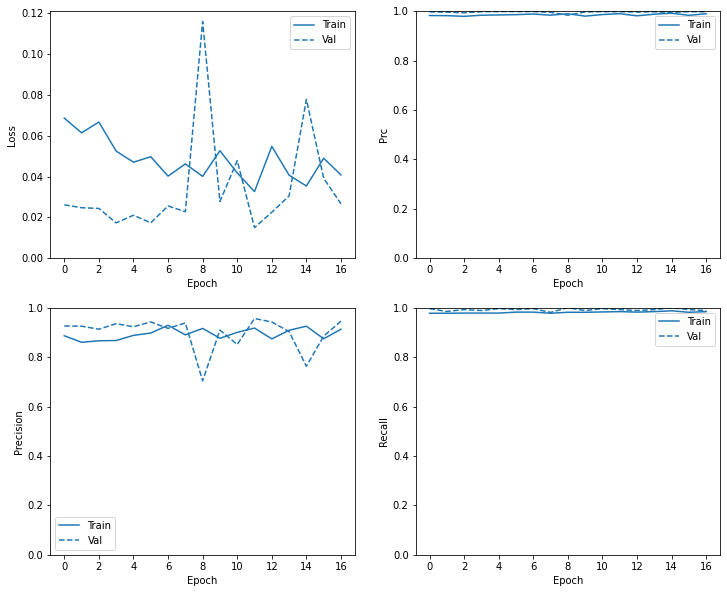

In [ ]:
plot_metrics(final_model_history)

In [ ]:
# set the filename with a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
history_pickle_file = "model_history_sunday" + timestamp + ".pkl"

# save the history object as a pickle file
with open(pickle_file_dir + history_pickle_file, "wb") as f:
    pickle.dump(final_model_history, f)

BELOW IS NOW REDUNDANT (AS MADE ANOTHER SCRIPT) CAN DELETE LATER

# Assess performance

User may wish to switch from a GPU to CPU runtime here



1. Load the saved model and inference on the test data
2. Check training history using train and validation data from the training process
3.   Inference on the test data and check the model still performs well




In [ ]:
from tensorflow.keras.models import load_model

# path may be in the sub folder 'best_model'
checkpoint_path = "/content/drive/MyDrive/bombs/data/final_dataset/autokeras_model_50repeats/best_model"
final_model = load_model(checkpoint_path)

# inference on the test data. If: 'test_features' is not defined, run the test files section under 'load dataset' near the start
#test_raw_predictions = final_model.predict(test_features)
test_raw_predictions = final_model.predict(test_features)

# Now inference on test data

reckon I can remove this part and save for a colab script that assesses how good the model was - where all the history metrics are plotted too.

DONT DELETE UNTIL I'VE MADE THIS SCRIPT THOUGH!

loss :  0.04517058655619621
tp :  243.0
fp :  5.0
tn :  995.0
fn :  7.0
accuracy :  0.9904000163078308
precision :  0.9798387289047241
recall :  0.972000002861023
auc :  0.9949380159378052
prc :  0.9902741312980652

Legitimate Transactions Detected (True Negatives):  995
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  7
Blasts detected (True Positives):  243
Total blasts:  250


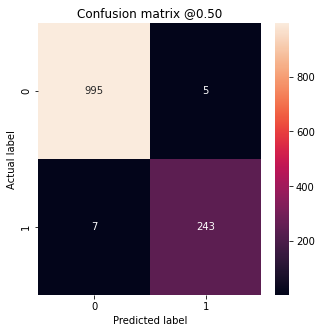

In [ ]:
test_evaluation = final_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(final_model.metrics_names, test_evaluation):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_raw_predictions)

In [ ]:
# filenames were not stored in pickle files so add back in here for the df
test_filenames = ['NB02518_M14_20220906_155400.WAV', 'NB02210_M14_20220914_052200.WAV', 'NB02331_M14_20220901_231400.WAV', 'NB02235_M14_20220916_084600.WAV', 'NB02511_M14_20220912_100400.WAV', 'NB02485_M14_20220918_210200.WAV', 'NB02436_M14_20220914_183400.WAV', 'NB02233_M14_20220901_162800.WAV', 'NB02265_M14_20220902_182800.WAV', 'NB02216_M14_20220919_025000.WAV', 'NB02242_M14_20220912_234800.WAV', 'NB02901_M16_20220911_131800.WAV', 'NB02814_M16_20220922_084400.WAV', 'NB02637_M16_20220831_123000.WAV', 'NB02944_M16_20220919_054600.WAV', 'NB02750_M16_20220922_124600.WAV', 'NB03025_M17_20220916_142600.WAV', 'NB02682_M16_20220831_120200.WAV', 'NB03036_M17_20220902_074200.WAV', 'NB02809_M16_20220908_162600.WAV', 'NB02993_M16_20220919_124000.WAV', 'NB02684_M16_20220901_092600.WAV', 'NB02806_M16_20220909_063000.WAV', 'NB02670_M16_20220903_053200.WAV', 'NB02907_M16_20220902_014200.WAV', 'NB02654_M16_20220915_215000.WAV', 'NB02674_M16_20220922_232600.WAV', 'NB02796_M16_20220922_153000.WAV', 'NB02864_M16_20220907_050200.WAV', 'NB02818_M16_20220925_143200.WAV', 'NB02929_M16_20220909_150800.WAV', 'NB03043_M17_20220912_214400.WAV', 'NB02691_M16_20220917_093000.WAV', 'NB03149_M17_20220914_181800.WAV', 'NB03378_M17_20220922_054200.WAV', 'NB03373_M17_20220914_095800.WAV', 'NB03292_M17_20220912_070400.WAV', 'NB03330_M17_20220920_123800.WAV', 'NB03289_M17_20220919_084200.WAV', 'NB03167_M17_20220830_094000.WAV', 'NB03303_M17_20220912_192600.WAV', 'NB03104_M17_20220914_052000.WAV', 'NB03371_M17_20220920_193600.WAV', 'NB03203_M17_20220902_171600.WAV', 'NB03138_M17_20220907_042200.WAV', 'NB03320_M17_20220908_111600.WAV', 'NB03328_M17_20220913_135600.WAV', 'NB03062_M17_20220922_000200.WAV', 'NB03439_M02_20220902_141800.WAV', 'NB03407_M02_20220908_080000.WAV', 'NB03180_M17_20220922_223400.WAV', 'NB03374_M17_20220920_073800.WAV', 'NB03597_M02_20220902_151000.WAV', 'NB03518_M02_20220901_205400.WAV', 'NB03614_M02_20220915_121800.WAV', 'NB03676_M02_20220913_103200.WAV', 'NB03758_M02_20220921_041800.WAV', 'NB03604_M02_20220901_032200.WAV', 'NB03596_M02_20220901_081600.WAV', 'NB03795_M02_20220915_224800.WAV', 'NB03444_M02_20220921_025600.WAV', 'NB03543_M02_20220908_051400.WAV', 'NB03895_M08_20220830_233600.WAV', 'NB03563_M02_20220907_215200.WAV', 'NB03627_M02_20220917_163600.WAV', 'NB03711_M02_20220829_143800.WAV', 'NB03469_M02_20220919_022400.WAV', 'NB03504_M02_20220917_042000.WAV', 'NB03534_M02_20220908_122600.WAV', 'NB03512_M02_20220902_002400.WAV', 'NB03576_M02_20220902_043600.WAV', 'NB03516_M02_20220831_002200.WAV', 'NB03861_M08_20220917_014600.WAV', 'NB03911_M08_20220831_175800.WAV', 'NB03862_M08_20220913_212000.WAV', 'NB03786_M02_20220911_045800.WAV', 'NB03503_M02_20220918_124600.WAV', 'NB03863_M08_20220909_182400.WAV', 'NB03761_M02_20220908_102400.WAV', 'NB03844_M08_20220915_050000.WAV', 'NB03641_M02_20220906_172800.WAV', 'NB03492_M02_20220919_164200.WAV', 'NB03787_M02_20220915_132600.WAV', 'NB03537_M02_20220830_024600.WAV', 'NB03770_M02_20220903_072800.WAV', 'NB03609_M02_20220914_115600.WAV', 'NB03629_M02_20220919_012600.WAV', 'NB03955_M08_20220919_081000.WAV', 'NB03928_M08_20220903_191000.WAV', 'NB04066_M08_20220922_034200.WAV', 'NB04056_M08_20220922_113800.WAV', 'NB03949_M08_20220908_180800.WAV', 'NB03926_M08_20220910_140600.WAV', 'NB04141_M08_20220918_150400.WAV', 'NB03972_M08_20220902_163800.WAV', 'NB04234_M01_20220911_142400.WAV', 'NB04151_M08_20220907_024600.WAV', 'NB04029_M08_20220922_110400.WAV', 'NB03948_M08_20220915_071600.WAV', 'NB04195_M08_20220911_043800.WAV', 'NB04023_M08_20220922_015800.WAV', 'NB04170_M08_20220920_120400.WAV', 'NB04032_M08_20220907_014200.WAV', 'NB04275_M01_20220913_234600.WAV', 'NB04561_M01_20220829_180600.WAV', 'NB04416_M01_20220910_083600.WAV', 'NB04502_M01_20220911_095400.WAV', 'NB04648_M10_20220902_111000.WAV', 'NB04343_M01_20220920_065600.WAV', 'NB04430_M01_20220911_114000.WAV', 'NB04694_M10_20220901_224200.WAV', 'NB04565_M01_20220921_065200.WAV', 'NB04318_M01_20220921_160400.WAV', 'NB04388_M01_20220922_054800.WAV', 'NB04357_M01_20220915_141200.WAV', 'NB04466_M01_20220830_153400.WAV', 'NB04493_M01_20220909_140600.WAV', 'NB04274_M01_20220918_232800.WAV', 'NB04688_M10_20220831_012200.WAV', 'NB04579_M01_20220902_134600.WAV', 'NB04261_M01_20220907_142000.WAV', 'NB04512_M01_20220910_201000.WAV', 'NB04548_M01_20220921_003000.WAV', 'NB04686_M10_20220904_032400.WAV', 'NB04549_M01_20220921_103800.WAV', 'NB04454_M01_20220903_124800.WAV', 'NB04264_M01_20220831_051600.WAV', 'NB04360_M01_20220922_114400.WAV', 'NB04743_M10_20220902_195400.WAV', 'NB05071_M11_20220901_204400.WAV', 'NB04744_M10_20220902_033800.WAV', 'NB05001_M11_20220919_104600.WAV', 'NB04863_M10_20220831_051200.WAV', 'NB04862_M10_20220903_000800.WAV', 'NB05165_M11_20220907_132600.WAV', 'NB04827_M10_20220901_125800.WAV', 'NB05124_M11_20220914_185400.WAV', 'NB04922_M10_20220904_025400.WAV', 'NB04818_M10_20220902_092400.WAV', 'NB04796_M10_20220830_183200.WAV', 'NB04940_M10_20220830_181200.WAV', 'NB04761_M10_20220901_123200.WAV', 'NB04790_M10_20220904_052000.WAV', 'NB05009_M11_20220916_143400.WAV', 'NB04968_M10_20220831_073200.WAV', 'NB05169_M11_20220901_040400.WAV', 'NB04959_M10_20220831_123600.WAV', 'NB05047_M11_20220908_114000.WAV', 'NB04952_M10_20220831_194400.WAV', 'NB05035_M11_20220910_060200.WAV', 'NB04813_M10_20220902_043200.WAV', 'NB04943_M10_20220902_094600.WAV', 'NB05061_M11_20220910_014400.WAV', 'NB04753_M10_20220831_102600.WAV', 'NB05016_M11_20220917_160600.WAV', 'NB04836_M10_20220901_202600.WAV', 'NB04707_M10_20220901_110000.WAV', 'NB05455_M04_20220919_173000.WAV', 'NB05225_M11_20220901_060200.WAV', 'NB05406_M04_20220830_121800.WAV', 'NB05217_M11_20220913_125200.WAV', 'NB05314_M11_20220907_073200.WAV', 'NB05277_M11_20220919_190000.WAV', 'NB05298_M11_20220902_082800.WAV', 'NB05417_M04_20220901_020600.WAV', 'NB05438_M04_20220914_003600.WAV', 'NB05398_M11_20220920_133600.WAV', 'NB05269_M11_20220911_224600.WAV', 'NB05236_M11_20220918_073200.WAV', 'NB05436_M04_20220831_013400.WAV', 'NB05468_M04_20220913_113200.WAV', 'NB05297_M11_20220921_124600.WAV', 'NB05413_M04_20220910_111800.WAV', 'NB05373_M11_20220916_033600.WAV', 'NB05407_M04_20220829_190400.WAV', 'NB05868_M05_20220901_072800.WAV', 'NB05885_M05_20220902_205400.WAV', 'NB05713_M04_20220901_062200.WAV', 'NB05872_M05_20220902_162000.WAV', 'NB05686_M04_20220922_111400.WAV', 'NB05765_M04_20220920_105600.WAV', 'NB05689_M04_20220920_024000.WAV', 'NB05629_M04_20220921_035600.WAV', 'NB05786_M04_20220906_141800.WAV', 'NB05569_M04_20220920_173200.WAV', 'NB05736_M04_20220910_150800.WAV', 'NB05830_M05_20220831_211400.WAV', 'NB05668_M04_20220916_221000.WAV', 'NB06094_M05_20220903_130000.WAV', 'NB05915_M05_20220901_220600.WAV', 'NB05975_M05_20220903_094000.WAV', 'NB06017_M05_20220903_205800.WAV', 'NB06018_M05_20220830_123800.WAV', 'NB06062_M05_20220830_214600.WAV', 'NB05978_M05_20220901_230200.WAV', 'NB06155_M05_20220831_230600.WAV', 'NB05962_M05_20220831_045200.WAV', 'NB06100_M05_20220903_160400.WAV', 'NB06031_M05_20220830_114000.WAV', 'NB06140_M05_20220901_165400.WAV', 'NB06075_M05_20220831_234400.WAV', 'NB06080_M05_20220831_031600.WAV', 'NB05926_M05_20220903_014200.WAV', 'NB06065_M05_20220830_202000.WAV', 'NB06009_M05_20220830_133000.WAV', 'NB06109_M05_20220902_232400.WAV', 'NB06013_M05_20220904_012800.WAV', 'NB06091_M05_20220830_112600.wav', 'NB05938_M05_20220831_100200.WAV', 'NB06061_M05_20220901_101400.WAV', 'NB06110_M05_20220902_171200.WAV', 'NB06024_M05_20220903_185400.WAV', 'NB05911_M05_20220901_180400.WAV', 'NB05976_M05_20220902_132600.WAV', 'NB05895_M05_20220831_232200.WAV', 'NB05921_M05_20220901_061400.WAV', 'NB06221_M07_20220901_000600.WAV', 'NB06426_M07_20220920_191000.WAV', 'NB06326_M07_20220909_024200.WAV', 'NB06596_M07_20220922_072800.WAV', 'NB06332_M07_20220920_102000.WAV', 'NB06230_M07_20220916_115800.WAV', 'NB06350_M07_20220912_202400.WAV', 'NB06368_M07_20220909_055000.WAV', 'NB06209_M07_20220923_183000.WAV', 'NB06253_M07_20220909_013800.WAV', 'NB06180_M05_20220830_073600.WAV', 'NB06361_M07_20220831_063800.WAV', 'NB06399_M07_20220831_024000.WAV', 'NB06380_M07_20220903_074200.WAV', 'NB06599_M07_20220910_071200.WAV', 'NB06231_M07_20220920_083400.WAV', 'NB06450_M07_20220831_155400.WAV', 'NB06436_M07_20220916_083200.WAV', 'NB06347_M07_20220916_023600.WAV', 'NB06477_M07_20220906_202000.WAV', 'NB06202_M07_20220831_010000.WAV', 'NB06564_M07_20220830_050800.WAV', 'NB07017_M15_20220915_065200.WAV', 'NB07033_M15_20220913_083000.WAV', 'NB06915_M12_20220907_232400.WAV', 'NB06728_M12_20220909_071200.WAV', 'NB06637_M12_20220901_031000.WAV', 'NB06851_M12_20220830_200400.WAV', 'NB06791_M12_20220916_014000.WAV', 'NB06821_M12_20220909_231600.WAV', 'NB06638_M12_20220901_205400.WAV', 'NB06968_M12_20220907_150400.WAV', 'NB06763_M12_20220902_072000.WAV', 'NB06643_M12_20220908_165800.WAV', 'NB06841_M12_20220908_094800.WAV', 'NB06676_M12_20220912_200000.WAV', 'NB07047_M15_20220831_135800.WAV', 'NB07065_M15_20220917_033000.WAV', 'NB06780_M12_20220914_050600.WAV', 'NB06959_M12_20220911_231000.WAV', 'NB06855_M12_20220903_030000.WAV', 'NB06625_M12_20220917_054800.WAV', 'NB06667_M12_20220910_144800.WAV', 'NB06918_M12_20220921_152000.WAV', 'NB06974_M12_20220916_032600.WAV', 'NB06867_M12_20220922_070800.WAV', 'NB06720_M12_20220921_163800.WAV', 'NB06926_M12_20220917_231400.WAV', 'NB06861_M12_20220903_115400.WAV', 'NB07364_M15_20220920_134200.WAV', 'NB07388_M15_20220902_045400.WAV', 'NB07432_M18_20220912_202600.WAV', 'NB07209_M15_20220912_130600.WAV', 'NB07186_M15_20220917_073800.WAV', 'NB07351_M15_20220914_170000.WAV', 'NB07093_M15_20220913_055000.WAV', 'NB07195_M15_20220919_132600.WAV', 'NB07097_M15_20220829_164400.WAV', 'NB07416_M18_20220911_090200.WAV', 'NB07342_M15_20220915_233000.WAV', 'NB07156_M15_20220909_180800.WAV', 'NB07207_M15_20220923_104600.WAV', 'NB07313_M15_20220907_191800.WAV', 'NB07373_M15_20220914_023600.WAV', 'NB07278_M15_20220907_035000.WAV', 'NB07283_M15_20220903_114000.WAV', 'NB07160_M15_20220907_184200.WAV', 'NB07203_M15_20220907_145000.WAV', 'NB07379_M15_20220907_104000.WAV', 'NB07287_M15_20220830_125400.WAV', 'NB07139_M15_20220922_234800.WAV', 'NB07205_M15_20220910_193600.WAV', 'NB07108_M15_20220902_092800.WAV', 'NB07437_M18_20220908_235200.WAV', 'NB07594_M18_20220915_181400.WAV', 'NB07598_M18_20220920_095200.WAV', 'NB07705_M18_20220902_010000.WAV', 'NB07789_M18_20220903_044400.WAV', 'NB07553_M18_20220914_184600.WAV', 'NB07500_M18_20220907_004800.WAV', 'NB07695_M18_20220907_151600.WAV', 'NB07532_M18_20220830_191000.WAV', 'NB07672_M18_20220910_214400.WAV', 'NB07736_M18_20220915_181200.WAV', 'NB07850_M03_20220915_001400.WAV', 'NB07571_M18_20220915_131600.WAV', 'NB07502_M18_20220914_010200.WAV', 'NB07907_M03_20220921_173800.WAV', 'NB07535_M18_20220917_021200.WAV', 'NB07864_M03_20220831_075600.WAV', 'NB07722_M18_20220915_072400.WAV', 'NB07740_M18_20220903_190800.WAV', 'NB07834_M03_20220902_203000.WAV', 'NB07879_M03_20220830_102400.WAV', 'NB07580_M18_20220901_024800.WAV', 'NB07895_M03_20220908_001600.WAV', 'NB07612_M18_20220920_080000.WAV', 'NB07449_M18_20220916_231400.WAV', 'NB07659_M18_20220910_114000.WAV', 'NB07530_M18_20220915_191600.WAV', 'NB07830_M03_20220910_073800.WAV', 'NB07870_M03_20220916_120800.WAV', 'NB07817_M03_20220917_204200.WAV', 'NB08022_M03_20220831_014600.WAV', 'NB08252_M06_20220902_201000.WAV', 'NB08358_M06_20220830_092200.WAV', 'NB07982_M03_20220915_080400.WAV', 'NB08204_M06_20220908_051800.WAV', 'NB08109_M03_20220904_074400.WAV', 'NB08145_M03_20220831_161600.WAV', 'NB08064_M03_20220902_000600.WAV', 'NB08243_M06_20220920_113800.WAV', 'NB08183_M03_20220830_064400.WAV', 'NB08062_M03_20220914_002600.WAV', 'NB08191_M03_20220916_104800.WAV', 'NB07928_M03_20220917_210800.WAV', 'NB08241_M06_20220917_025200.WAV', 'NB07973_M03_20220915_194600.WAV', 'NB07956_M03_20220917_071400.WAV', 'NB08182_M03_20220909_153600.WAV', 'NB08334_M06_20220918_183400.WAV', 'NB08297_M06_20220915_162600.WAV', 'NB08271_M06_20220917_041800.WAV', 'NB08288_M06_20220917_071800.WAV', 'NB07943_M03_20220919_074200.WAV', 'NB08172_M03_20220919_104800.WAV', 'NB08059_M03_20220903_053400.WAV', 'NB07983_M03_20220919_213400.WAV', 'NB08671_M09_20220912_032600.WAV', 'NB08531_M06_20220912_160200.WAV', 'NB08672_M09_20220913_112800.WAV', 'NB08779_M09_20220902_212600.WAV', 'NB08498_M06_20220916_201800.WAV', 'NB08820_M09_20220903_120200.WAV', 'NB08636_M09_20220830_052800.WAV', 'NB08777_M09_20220922_211000.WAV', 'NB08412_M06_20220830_123000.WAV', 'NB08406_M06_20220908_054800.WAV', 'NB08614_M09_20220830_122000.WAV', 'NB08397_M06_20220917_191800.WAV', 'NB08734_M09_20220913_111600.WAV', 'NB08726_M09_20220921_053200.WAV', 'NB08421_M06_20220915_170200.WAV', 'NB08815_M09_20220921_102800.WAV', 'NB08800_M09_20220901_060600.WAV', 'NB08790_M09_20220830_001400.WAV', 'NB08606_M09_20220914_065200.WAV', 'NB08390_M06_20220829_153400.WAV', 'NB08723_M09_20220922_081600.WAV', 'NB08510_M06_20220917_031800.WAV', 'NB08922_M09_20220907_155600.WAV', 'NB08845_M09_20220908_160200.WAV', 'NB08856_M09_20220913_151200.WAV', 'NB08881_M09_20220912_222000.WAV', 'NB08950_M09_20220830_005000.WAV', 'NB08985_M09_20220916_111000.WAV', 'NB08980_M09_20220915_221000.WAV', 'NB08866_M09_20220916_073400.WAV', 'NB08824_M09_20220918_035200.WAV', 'NB00001_M13_20220902_052800_augmented1.wav', 'NB00107_M14_20220918_105600_augmented1.wav', 'NB00113_M14_20220915_095000_augmented1.wav', 'NB00144_M14_20220830_082800_augmented1.wav', 'NB00169_M14_20220921_191600_augmented1.wav', 'NB00172_M14_20220913_101600_augmented1.wav', 'NB00174_M14_20220912_193600_augmented1.wav', 'NB00220_M16_20220913_012200_augmented1.wav', 'NB00231_M16_20220912_183600_augmented1.wav', 'NB00240_M16_20220923_152000_augmented1.wav', 'NB00254_M16_20220902_091000_augmented1.wav', 'NB00261_M16_20220913_115400_augmented1.wav', 'NB00264_M16_20220911_084600_augmented1.wav', 'NB00273_M16_20220913_013400_augmented1.wav', 'NB00272_M16_20220904_000200_augmented1.wav', 'NB00276_M16_20220912_123800_augmented1.wav', 'NB00310_M17_20220915_044800_augmented1.wav', 'NB00330_M17_20220914_180600_augmented1.wav', 'NB00373_M17_20220908_222000_augmented1.wav', 'NB00390_M17_20220902_225000_augmented1.wav', 'NB00478_M02_20220919_114800_augmented1.wav', 'NB00475_M02_20220912_083200_augmented1.wav', 'NB00492_M02_20220903_062000_augmented1.wav', 'NB00517_M08_20220903_210200_augmented1.wav', 'NB00527_M08_20220915_063200_augmented1.wav', 'NB00587_M08_20220830_160800_augmented1.wav', 'NB00586_M08_20220912_032600_augmented1.wav', 'NB00629_M01_20220917_102400_augmented1.wav', 'NB00642_M01_20220907_103800_augmented1.wav', 'NB00648_M01_20220910_165400_augmented1.wav', 'NB00661_M01_20220913_003400_augmented1.wav', 'NB00671_M01_20220916_012600_augmented1.wav', 'NB00672_M01_20220907_191800_augmented1.wav', 'NB00710_M10_20220830_200600_augmented1.wav', 'NB00725_M10_20220901_114200_augmented1.wav', 'NB00735_M10_20220830_094400_augmented1.wav', 'NB00792_M10_20220904_090000_augmented1.wav', 'NB00794_M10_20220903_120400_augmented1.wav', 'NB00807_M11_20220902_200600_augmented1.wav', 'NB00833_M11_20220831_043000_augmented1.wav', 'NB00870_M11_20220910_153800_augmented1.wav', 'NB00889_M11_20220831_220200_augmented1.wav', 'NB00907_M04_20220912_025600_augmented1.wav', 'NB00954_M04_20220919_060200_augmented1.wav', 'NB00968_M04_20220913_104800_augmented1.wav', 'NB01001_M05_20220830_122200_augmented1.wav', 'NB01012_M05_20220903_064400_augmented1.wav', 'NB01037_M05_20220901_121000_augmented1.wav', 'NB01050_M05_20220831_093200_augmented1.wav', 'NB01052_M05_20220830_195400_augmented1.wav', 'NB01066_M05_20220903_142000_augmented1.wav', 'NB01072_M05_20220902_171600_augmented1.wav', 'NB01115_M07_20220910_060800_augmented1.wav', 'NB01134_M07_20220830_230000_augmented1.wav', 'NB01152_M07_20220924_040000_augmented1.wav', 'NB01171_M07_20220830_180200_augmented1.wav', 'NB01175_M07_20220902_142400_augmented1.wav', 'NB01189_M07_20220829_112800_augmented1.wav', 'NB01198_M07_20220829_103000_augmented1.wav', 'NB01209_M12_20220914_182800_augmented1.wav', 'NB01219_M12_20220831_103400_augmented1.wav', 'NB01227_M12_20220830_014800_augmented1.wav', 'NB01251_M12_20220911_100800_augmented1.wav', 'NB01268_M12_20220914_121400_augmented1.wav', 'NB01284_M12_20220921_024800_augmented1.wav', 'NB01287_M12_20220915_221800_augmented1.wav', 'NB01296_M12_20220902_032600_augmented1.wav', 'NB01301_M15_20220912_224800_augmented1.wav', 'NB01414_M18_20220910_071800_augmented1.wav', 'NB01428_M18_20220904_064400_augmented1.wav', 'NB01485_M18_20220921_205800_augmented1.wav', 'NB01489_M18_20220916_231000_augmented1.wav', 'NB01497_M18_20220908_025400_augmented1.wav', 'NB01498_M18_20220910_102000_augmented1.wav', 'NB01504_M03_20220914_131000_augmented1.wav', 'NB01515_M03_20220902_204600_augmented1.wav', 'NB01538_M03_20220909_004600_augmented1.wav', 'NB01552_M03_20220920_195600_augmented1.wav', 'NB01548_M03_20220911_224200_augmented1.wav', 'NB01573_M03_20220915_200400_augmented1.wav', 'NB01575_M03_20220912_000200_augmented1.wav', 'NB01582_M03_20220911_211000_augmented1.wav', 'NB01622_M06_20220919_094000_augmented1.wav', 'NB01647_M06_20220908_125200_augmented1.wav', 'NB01683_M06_20220922_145800_augmented1.wav', 'NB01687_M06_20220903_155400_augmented1.wav', 'NB01711_M09_20220831_234000_augmented1.wav', 'NB01710_M09_20220912_041400_augmented1.wav', 'NB01725_M09_20220912_233600_augmented1.wav', 'NB01745_M09_20220912_021000_augmented1.wav', 'NB01766_M09_20220912_071000_augmented1.wav', 'NB01791_M09_20220918_103200_augmented1.wav', 'NB01813_M13_20220917_114600_augmented1.wav', 'NB01825_M13_20220909_081200_augmented1.wav', 'NB01841_M13_20220831_011600_augmented1.wav', 'NB01878_M13_20220915_201600_augmented1.wav', 'NB01903_M13_20220913_225600_augmented1.wav', 'NB01916_M13_20220909_102200_augmented1.wav', 'NB01933_M13_20220919_195200_augmented1.wav', 'NB02004_M13_20220901_213600_augmented1.wav', 'NB02017_M13_20220915_202600_augmented1.wav', 'NB02018_M13_20220909_010800_augmented1.wav', 'NB02036_M13_20220902_200600_augmented1.wav', 'NB02055_M13_20220921_113200_augmented1.wav', 'NB02065_M13_20220917_181000_augmented1.wav', 'NB02111_M13_20220903_214200_augmented1.wav', 'NB02115_M13_20220831_021600_augmented1.wav', 'NB02127_M13_20220902_175400_augmented1.wav', 'NB02177_M13_20220831_123400_augmented1.wav', 'NB02206_M14_20220913_221000_augmented1.wav', 'NB02210_M14_20220914_052200_augmented1.wav', 'NB02216_M14_20220919_025000_augmented1.wav', 'NB02233_M14_20220901_162800_augmented1.wav', 'NB02235_M14_20220916_084600_augmented1.wav', 'NB02242_M14_20220912_234800_augmented1.wav', 'NB02265_M14_20220902_182800_augmented1.wav', 'NB02294_M14_20220913_210800_augmented1.wav', 'NB02331_M14_20220901_231400_augmented1.wav', 'NB02336_M14_20220920_185600_augmented1.wav', 'NB02361_M14_20220922_102000_augmented1.wav', 'NB02369_M14_20220917_034200_augmented1.wav', 'NB02398_M14_20220903_130200_augmented1.wav', 'NB02403_M14_20220923_070200_augmented1.wav', 'NB02412_M14_20220918_141400_augmented1.wav', 'NB02433_M14_20220921_122600_augmented1.wav', 'NB02436_M14_20220914_183400_augmented1.wav', 'NB02455_M14_20220915_212800_augmented1.wav', 'NB02453_M14_20220831_013800_augmented1.wav', 'NB02474_M14_20220911_122000_augmented1.wav', 'NB02485_M14_20220918_210200_augmented1.wav', 'NB02494_M14_20220922_211400_augmented1.wav', 'NB02511_M14_20220912_100400_augmented1.wav', 'NB02518_M14_20220906_155400_augmented1.wav', 'NB02526_M14_20220901_234800_augmented1.wav', 'NB02575_M14_20220907_113200_augmented1.wav', 'NB02607_M16_20220917_050600_augmented1.wav', 'NB02637_M16_20220831_123000_augmented1.wav', 'NB02654_M16_20220915_215000_augmented1.wav', 'NB02670_M16_20220903_053200_augmented1.wav', 'NB02674_M16_20220922_232600_augmented1.wav', 'NB02684_M16_20220901_092600_augmented1.wav', 'NB02682_M16_20220831_120200_augmented1.wav', 'NB02691_M16_20220917_093000_augmented1.wav', 'NB02750_M16_20220922_124600_augmented1.wav', 'NB02796_M16_20220922_153000_augmented1.wav', 'NB02806_M16_20220909_063000_augmented1.wav', 'NB02814_M16_20220922_084400_augmented1.wav', 'NB02809_M16_20220908_162600_augmented1.wav', 'NB02818_M16_20220925_143200_augmented1.wav', 'NB02864_M16_20220907_050200_augmented1.wav', 'NB02901_M16_20220911_131800_augmented1.wav', 'NB02907_M16_20220902_014200_augmented1.wav', 'NB02929_M16_20220909_150800_augmented1.wav', 'NB02944_M16_20220919_054600_augmented1.wav', 'NB02993_M16_20220919_124000_augmented1.wav', 'NB03025_M17_20220916_142600_augmented1.wav', 'NB03036_M17_20220902_074200_augmented1.wav', 'NB03043_M17_20220912_214400_augmented1.wav', 'NB03062_M17_20220922_000200_augmented1.wav', 'NB03104_M17_20220914_052000_augmented1.wav', 'NB03138_M17_20220907_042200_augmented1.wav', 'NB03149_M17_20220914_181800_augmented1.wav', 'NB03167_M17_20220830_094000_augmented1.wav', 'NB03180_M17_20220922_223400_augmented1.wav', 'NB03203_M17_20220902_171600_augmented1.wav', 'NB03289_M17_20220919_084200_augmented1.wav', 'NB03292_M17_20220912_070400_augmented1.wav', 'NB03303_M17_20220912_192600_augmented1.wav', 'NB03320_M17_20220908_111600_augmented1.wav', 'NB03330_M17_20220920_123800_augmented1.wav', 'NB03328_M17_20220913_135600_augmented1.wav', 'NB03371_M17_20220920_193600_augmented1.wav', 'NB03373_M17_20220914_095800_augmented1.wav', 'NB03374_M17_20220920_073800_augmented1.wav', 'NB03378_M17_20220922_054200_augmented1.wav', 'NB03407_M02_20220908_080000_augmented1.wav', 'NB03439_M02_20220902_141800_augmented1.wav', 'NB03444_M02_20220921_025600_augmented1.wav', 'NB03469_M02_20220919_022400_augmented1.wav', 'NB03492_M02_20220919_164200_augmented1.wav', 'NB03504_M02_20220917_042000_augmented1.wav', 'NB03503_M02_20220918_124600_augmented1.wav', 'NB03512_M02_20220902_002400_augmented1.wav', 'NB03516_M02_20220831_002200_augmented1.wav', 'NB03518_M02_20220901_205400_augmented1.wav', 'NB03534_M02_20220908_122600_augmented1.wav', 'NB03537_M02_20220830_024600_augmented1.wav', 'NB03543_M02_20220908_051400_augmented1.wav', 'NB03563_M02_20220907_215200_augmented1.wav', 'NB03576_M02_20220902_043600_augmented1.wav', 'NB03596_M02_20220901_081600_augmented1.wav', 'NB03597_M02_20220902_151000_augmented1.wav', 'NB03604_M02_20220901_032200_augmented1.wav', 'NB03609_M02_20220914_115600_augmented1.wav', 'NB03614_M02_20220915_121800_augmented1.wav', 'NB03629_M02_20220919_012600_augmented1.wav', 'NB03627_M02_20220917_163600_augmented1.wav', 'NB03641_M02_20220906_172800_augmented1.wav', 'NB03676_M02_20220913_103200_augmented1.wav', 'NB03711_M02_20220829_143800_augmented1.wav', 'NB03758_M02_20220921_041800_augmented1.wav', 'NB03761_M02_20220908_102400_augmented1.wav', 'NB03770_M02_20220903_072800_augmented1.wav', 'NB03786_M02_20220911_045800_augmented1.wav', 'NB03787_M02_20220915_132600_augmented1.wav', 'NB03795_M02_20220915_224800_augmented1.wav', 'NB03844_M08_20220915_050000_augmented1.wav', 'NB03862_M08_20220913_212000_augmented1.wav', 'NB03861_M08_20220917_014600_augmented1.wav', 'NB03863_M08_20220909_182400_augmented1.wav', 'NB03895_M08_20220830_233600_augmented1.wav', 'NB03911_M08_20220831_175800_augmented1.wav', 'NB03926_M08_20220910_140600_augmented1.wav', 'NB03928_M08_20220903_191000_augmented1.wav', 'NB03949_M08_20220908_180800_augmented1.wav', 'NB03948_M08_20220915_071600_augmented1.wav', 'NB03955_M08_20220919_081000_augmented1.wav', 'NB03972_M08_20220902_163800_augmented1.wav', 'NB04023_M08_20220922_015800_augmented1.wav', 'NB04029_M08_20220922_110400_augmented1.wav', 'NB04032_M08_20220907_014200_augmented1.wav', 'NB04056_M08_20220922_113800_augmented1.wav', 'NB04066_M08_20220922_034200_augmented1.wav', 'NB04141_M08_20220918_150400_augmented1.wav', 'NB04151_M08_20220907_024600_augmented1.wav', 'NB04170_M08_20220920_120400_augmented1.wav', 'NB04195_M08_20220911_043800_augmented1.wav', 'NB04234_M01_20220911_142400_augmented1.wav', 'NB04261_M01_20220907_142000_augmented1.wav', 'NB04264_M01_20220831_051600_augmented1.wav', 'NB04274_M01_20220918_232800_augmented1.wav', 'NB04275_M01_20220913_234600_augmented1.wav', 'NB04318_M01_20220921_160400_augmented1.wav', 'NB04343_M01_20220920_065600_augmented1.wav', 'NB04357_M01_20220915_141200_augmented1.wav', 'NB04360_M01_20220922_114400_augmented1.wav', 'NB04388_M01_20220922_054800_augmented1.wav', 'NB04416_M01_20220910_083600_augmented1.wav', 'NB04430_M01_20220911_114000_augmented1.wav', 'NB04454_M01_20220903_124800_augmented1.wav', 'NB04466_M01_20220830_153400_augmented1.wav', 'NB04493_M01_20220909_140600_augmented1.wav', 'NB04502_M01_20220911_095400_augmented1.wav', 'NB04512_M01_20220910_201000_augmented1.wav', 'NB04548_M01_20220921_003000_augmented1.wav', 'NB04549_M01_20220921_103800_augmented1.wav', 'NB04561_M01_20220829_180600_augmented1.wav', 'NB04565_M01_20220921_065200_augmented1.wav', 'NB04579_M01_20220902_134600_augmented1.wav', 'NB04648_M10_20220902_111000_augmented1.wav', 'NB04686_M10_20220904_032400_augmented1.wav', 'NB04688_M10_20220831_012200_augmented1.wav', 'NB04694_M10_20220901_224200_augmented1.wav', 'NB04707_M10_20220901_110000_augmented1.wav', 'NB04744_M10_20220902_033800_augmented1.wav', 'NB04743_M10_20220902_195400_augmented1.wav', 'NB04753_M10_20220831_102600_augmented1.wav', 'NB04761_M10_20220901_123200_augmented1.wav', 'NB04790_M10_20220904_052000_augmented1.wav', 'NB04796_M10_20220830_183200_augmented1.wav', 'NB04813_M10_20220902_043200_augmented1.wav', 'NB04818_M10_20220902_092400_augmented1.wav', 'NB04827_M10_20220901_125800_augmented1.wav', 'NB04836_M10_20220901_202600_augmented1.wav', 'NB04863_M10_20220831_051200_augmented1.wav', 'NB04862_M10_20220903_000800_augmented1.wav', 'NB04922_M10_20220904_025400_augmented1.wav', 'NB04940_M10_20220830_181200_augmented1.wav', 'NB04943_M10_20220902_094600_augmented1.wav', 'NB04952_M10_20220831_194400_augmented1.wav', 'NB04959_M10_20220831_123600_augmented1.wav', 'NB04968_M10_20220831_073200_augmented1.wav', 'NB05001_M11_20220919_104600_augmented1.wav', 'NB05009_M11_20220916_143400_augmented1.wav', 'NB05016_M11_20220917_160600_augmented1.wav', 'NB05035_M11_20220910_060200_augmented1.wav', 'NB05047_M11_20220908_114000_augmented1.wav', 'NB05061_M11_20220910_014400_augmented1.wav', 'NB05071_M11_20220901_204400_augmented1.wav', 'NB05124_M11_20220914_185400_augmented1.wav', 'NB05165_M11_20220907_132600_augmented1.wav', 'NB05169_M11_20220901_040400_augmented1.wav', 'NB05217_M11_20220913_125200_augmented1.wav', 'NB05225_M11_20220901_060200_augmented1.wav', 'NB05236_M11_20220918_073200_augmented1.wav', 'NB05269_M11_20220911_224600_augmented1.wav', 'NB05277_M11_20220919_190000_augmented1.wav', 'NB05298_M11_20220902_082800_augmented1.wav', 'NB05297_M11_20220921_124600_augmented1.wav', 'NB05314_M11_20220907_073200_augmented1.wav', 'NB05373_M11_20220916_033600_augmented1.wav', 'NB05398_M11_20220920_133600_augmented1.wav', 'NB05406_M04_20220830_121800_augmented1.wav', 'NB05407_M04_20220829_190400_augmented1.wav', 'NB05413_M04_20220910_111800_augmented1.wav', 'NB05417_M04_20220901_020600_augmented1.wav', 'NB05436_M04_20220831_013400_augmented1.wav', 'NB05438_M04_20220914_003600_augmented1.wav', 'NB05455_M04_20220919_173000_augmented1.wav', 'NB05468_M04_20220913_113200_augmented1.wav', 'NB05569_M04_20220920_173200_augmented1.wav', 'NB05629_M04_20220921_035600_augmented1.wav', 'NB05668_M04_20220916_221000_augmented1.wav', 'NB05686_M04_20220922_111400_augmented1.wav', 'NB05689_M04_20220920_024000_augmented1.wav', 'NB05713_M04_20220901_062200_augmented1.wav', 'NB05736_M04_20220910_150800_augmented1.wav', 'NB05765_M04_20220920_105600_augmented1.wav', 'NB05786_M04_20220906_141800_augmented1.wav', 'NB05830_M05_20220831_211400_augmented1.wav', 'NB05868_M05_20220901_072800_augmented1.wav', 'NB05872_M05_20220902_162000_augmented1.wav', 'NB05885_M05_20220902_205400_augmented1.wav', 'NB05895_M05_20220831_232200_augmented1.wav', 'NB05911_M05_20220901_180400_augmented1.wav', 'NB05915_M05_20220901_220600_augmented1.wav', 'NB05921_M05_20220901_061400_augmented1.wav', 'NB05926_M05_20220903_014200_augmented1.wav', 'NB05938_M05_20220831_100200_augmented1.wav', 'NB05962_M05_20220831_045200_augmented1.wav', 'NB05975_M05_20220903_094000_augmented1.wav', 'NB05978_M05_20220901_230200_augmented1.wav', 'NB05976_M05_20220902_132600_augmented1.wav', 'NB06009_M05_20220830_133000_augmented1.wav', 'NB06013_M05_20220904_012800_augmented1.wav', 'NB06018_M05_20220830_123800_augmented1.wav', 'NB06017_M05_20220903_205800_augmented1.wav', 'NB06024_M05_20220903_185400_augmented1.wav', 'NB06031_M05_20220830_114000_augmented1.wav', 'NB06061_M05_20220901_101400_augmented1.wav', 'NB06062_M05_20220830_214600_augmented1.wav', 'NB06065_M05_20220830_202000_augmented1.wav', 'NB06075_M05_20220831_234400_augmented1.wav', 'NB06080_M05_20220831_031600_augmented1.wav', 'NB06091_M05_20220830_112600_augmented1.wav', 'NB06094_M05_20220903_130000_augmented1.wav', 'NB06100_M05_20220903_160400_augmented1.wav', 'NB06109_M05_20220902_232400_augmented1.wav', 'NB06110_M05_20220902_171200_augmented1.wav', 'NB06140_M05_20220901_165400_augmented1.wav', 'NB06155_M05_20220831_230600_augmented1.wav', 'NB06180_M05_20220830_073600_augmented1.wav', 'NB06202_M07_20220831_010000_augmented1.wav', 'NB06209_M07_20220923_183000_augmented1.wav', 'NB06221_M07_20220901_000600_augmented1.wav', 'NB06230_M07_20220916_115800_augmented1.wav', 'NB06231_M07_20220920_083400_augmented1.wav', 'NB06253_M07_20220909_013800_augmented1.wav', 'NB06326_M07_20220909_024200_augmented1.wav', 'NB06332_M07_20220920_102000_augmented1.wav', 'NB06347_M07_20220916_023600_augmented1.wav', 'NB06350_M07_20220912_202400_augmented1.wav', 'NB06361_M07_20220831_063800_augmented1.wav', 'NB06368_M07_20220909_055000_augmented1.wav', 'NB06380_M07_20220903_074200_augmented1.wav', 'NB06399_M07_20220831_024000_augmented1.wav', 'NB06426_M07_20220920_191000_augmented1.wav', 'NB06436_M07_20220916_083200_augmented1.wav', 'NB06450_M07_20220831_155400_augmented1.wav', 'NB06477_M07_20220906_202000_augmented1.wav', 'NB06564_M07_20220830_050800_augmented1.wav', 'NB06596_M07_20220922_072800_augmented1.wav', 'NB06599_M07_20220910_071200_augmented1.wav', 'NB06625_M12_20220917_054800_augmented1.wav', 'NB06637_M12_20220901_031000_augmented1.wav', 'NB06638_M12_20220901_205400_augmented1.wav', 'NB06643_M12_20220908_165800_augmented1.wav', 'NB06667_M12_20220910_144800_augmented1.wav', 'NB06676_M12_20220912_200000_augmented1.wav', 'NB06720_M12_20220921_163800_augmented1.wav', 'NB06728_M12_20220909_071200_augmented1.wav', 'NB06763_M12_20220902_072000_augmented1.wav', 'NB06780_M12_20220914_050600_augmented1.wav', 'NB06791_M12_20220916_014000_augmented1.wav', 'NB06821_M12_20220909_231600_augmented1.wav', 'NB06841_M12_20220908_094800_augmented1.wav', 'NB06851_M12_20220830_200400_augmented1.wav', 'NB06855_M12_20220903_030000_augmented1.wav', 'NB06861_M12_20220903_115400_augmented1.wav', 'NB06867_M12_20220922_070800_augmented1.wav', 'NB06915_M12_20220907_232400_augmented1.wav', 'NB06918_M12_20220921_152000_augmented1.wav', 'NB06926_M12_20220917_231400_augmented1.wav', 'NB06959_M12_20220911_231000_augmented1.wav', 'NB06968_M12_20220907_150400_augmented1.wav', 'NB06974_M12_20220916_032600_augmented1.wav', 'NB07017_M15_20220915_065200_augmented1.wav', 'NB07033_M15_20220913_083000_augmented1.wav', 'NB07047_M15_20220831_135800_augmented1.wav', 'NB07065_M15_20220917_033000_augmented1.wav', 'NB07093_M15_20220913_055000_augmented1.wav', 'NB07097_M15_20220829_164400_augmented1.wav', 'NB07108_M15_20220902_092800_augmented1.wav', 'NB07139_M15_20220922_234800_augmented1.wav', 'NB07160_M15_20220907_184200_augmented1.wav', 'NB07156_M15_20220909_180800_augmented1.wav', 'NB07186_M15_20220917_073800_augmented1.wav', 'NB07195_M15_20220919_132600_augmented1.wav', 'NB07203_M15_20220907_145000_augmented1.wav', 'NB07205_M15_20220910_193600_augmented1.wav', 'NB07207_M15_20220923_104600_augmented1.wav', 'NB07209_M15_20220912_130600_augmented1.wav', 'NB07278_M15_20220907_035000_augmented1.wav', 'NB07283_M15_20220903_114000_augmented1.wav', 'NB07287_M15_20220830_125400_augmented1.wav', 'NB07313_M15_20220907_191800_augmented1.wav', 'NB07342_M15_20220915_233000_augmented1.wav', 'NB07351_M15_20220914_170000_augmented1.wav', 'NB07364_M15_20220920_134200_augmented1.wav', 'NB07373_M15_20220914_023600_augmented1.wav', 'NB07379_M15_20220907_104000_augmented1.wav', 'NB07388_M15_20220902_045400_augmented1.wav', 'NB07416_M18_20220911_090200_augmented1.wav', 'NB07432_M18_20220912_202600_augmented1.wav', 'NB07437_M18_20220908_235200_augmented1.wav', 'NB07449_M18_20220916_231400_augmented1.wav', 'NB07500_M18_20220907_004800_augmented1.wav', 'NB07502_M18_20220914_010200_augmented1.wav', 'NB07530_M18_20220915_191600_augmented1.wav', 'NB07532_M18_20220830_191000_augmented1.wav', 'NB07535_M18_20220917_021200_augmented1.wav', 'NB07553_M18_20220914_184600_augmented1.wav', 'NB07571_M18_20220915_131600_augmented1.wav', 'NB07580_M18_20220901_024800_augmented1.wav', 'NB07594_M18_20220915_181400_augmented1.wav', 'NB07598_M18_20220920_095200_augmented1.wav', 'NB07612_M18_20220920_080000_augmented1.wav', 'NB07659_M18_20220910_114000_augmented1.wav', 'NB07672_M18_20220910_214400_augmented1.wav', 'NB07695_M18_20220907_151600_augmented1.wav', 'NB07705_M18_20220902_010000_augmented1.wav', 'NB07722_M18_20220915_072400_augmented1.wav', 'NB07736_M18_20220915_181200_augmented1.wav', 'NB07740_M18_20220903_190800_augmented1.wav', 'NB07789_M18_20220903_044400_augmented1.wav', 'NB07817_M03_20220917_204200_augmented1.wav', 'NB07830_M03_20220910_073800_augmented1.wav', 'NB07834_M03_20220902_203000_augmented1.wav', 'NB07850_M03_20220915_001400_augmented1.wav', 'NB07864_M03_20220831_075600_augmented1.wav', 'NB07870_M03_20220916_120800_augmented1.wav', 'NB07879_M03_20220830_102400_augmented1.wav', 'NB07895_M03_20220908_001600_augmented1.wav', 'NB07907_M03_20220921_173800_augmented1.wav', 'NB07928_M03_20220917_210800_augmented1.wav', 'NB07943_M03_20220919_074200_augmented1.wav', 'NB07956_M03_20220917_071400_augmented1.wav', 'NB07973_M03_20220915_194600_augmented1.wav', 'NB07983_M03_20220919_213400_augmented1.wav', 'NB07982_M03_20220915_080400_augmented1.wav', 'NB08022_M03_20220831_014600_augmented1.wav', 'NB08059_M03_20220903_053400_augmented1.wav', 'NB08064_M03_20220902_000600_augmented1.wav', 'NB08062_M03_20220914_002600_augmented1.wav', 'NB08109_M03_20220904_074400_augmented1.wav', 'NB08145_M03_20220831_161600_augmented1.wav', 'NB08172_M03_20220919_104800_augmented1.wav', 'NB08183_M03_20220830_064400_augmented1.wav', 'NB08182_M03_20220909_153600_augmented1.wav', 'NB08191_M03_20220916_104800_augmented1.wav', 'NB08204_M06_20220908_051800_augmented1.wav', 'NB08241_M06_20220917_025200_augmented1.wav', 'NB08243_M06_20220920_113800_augmented1.wav', 'NB08252_M06_20220902_201000_augmented1.wav', 'NB08271_M06_20220917_041800_augmented1.wav', 'NB08288_M06_20220917_071800_augmented1.wav', 'NB08297_M06_20220915_162600_augmented1.wav', 'NB08334_M06_20220918_183400_augmented1.wav', 'NB08358_M06_20220830_092200_augmented1.wav', 'NB08390_M06_20220829_153400_augmented1.wav', 'NB08397_M06_20220917_191800_augmented1.wav', 'NB08406_M06_20220908_054800_augmented1.wav', 'NB08412_M06_20220830_123000_augmented1.wav', 'NB08421_M06_20220915_170200_augmented1.wav', 'NB08498_M06_20220916_201800_augmented1.wav', 'NB08510_M06_20220917_031800_augmented1.wav', 'NB08531_M06_20220912_160200_augmented1.wav', 'NB08606_M09_20220914_065200_augmented1.wav', 'NB08614_M09_20220830_122000_augmented1.wav', 'NB08636_M09_20220830_052800_augmented1.wav', 'NB08672_M09_20220913_112800_augmented1.wav', 'NB08671_M09_20220912_032600_augmented1.wav', 'NB08723_M09_20220922_081600_augmented1.wav', 'NB08726_M09_20220921_053200_augmented1.wav', 'NB08734_M09_20220913_111600_augmented1.wav', 'NB08777_M09_20220922_211000_augmented1.wav', 'NB08779_M09_20220902_212600_augmented1.wav', 'NB08790_M09_20220830_001400_augmented1.wav', 'NB08800_M09_20220901_060600_augmented1.wav', 'NB08815_M09_20220921_102800_augmented1.wav', 'NB08820_M09_20220903_120200_augmented1.wav', 'NB08824_M09_20220918_035200_augmented1.wav', 'NB08845_M09_20220908_160200_augmented1.wav', 'NB08856_M09_20220913_151200_augmented1.wav', 'NB08866_M09_20220916_073400_augmented1.wav', 'NB08881_M09_20220912_222000_augmented1.wav', 'NB08922_M09_20220907_155600_augmented1.wav', 'NB08950_M09_20220830_005000_augmented1.wav', 'NB08980_M09_20220915_221000_augmented1.wav', 'NB08985_M09_20220916_111000_augmented1.wav', 'YB00013_M02_20220901_082000_augmented5.wav', 'YB00031_M04_20220908_170600_augmented5.wav', 'YB00027_M03_20220906_165800_augmented5.wav', 'YB00034_M04_20220911_093600_augmented5.wav', 'YB00049_M06_20220914_124800_augmented5.wav', 'YB00057_M07_20220915_121000_augmented5.wav', 'YB00065_M08_20220919_115400_augmented5.wav', 'YB00062_M08_20220915_165600_augmented5.wav', 'YB00067_M08_20220919_134600_augmented5.wav', 'YB00075_M09_20220922_114200_augmented5.wav', 'YB00083_M10_20220831_103400_augmented5.wav', 'YB00079_M09_20220830_110000_augmented5.wav', 'YB00124_M14_20220915_083200_augmented5.wav', 'YB00129_M14_20220919_115400_augmented5.wav', 'YB00141_M16_20220922_103600_augmented5.wav', 'YB00143_M16_20220922_114200_augmented5.wav', 'YB00152_M17_20220902_084000_augmented5.wav', 'YB00154_M17_20220902_154000_augmented5.wav', 'YB00155_M17_20220902_161800_augmented5.wav', 'YB00165_M18_20220908_093600_augmented5.wav', 'YB00171_M05_20220830_110000_augmented5.wav', 'YB00174_M05_20220830_110800_augmented5.wav', 'YB00192_M09_20220830_131400_augmented5.wav', 'YB00200_M05_20220830_150600_augmented5.wav', 'YB00196_M07_20220915_151000_augmented5.wav', 'YB00013_M02_20220901_082000_augmented6.wav', 'YB00027_M03_20220906_165800_augmented6.wav', 'YB00031_M04_20220908_170600_augmented6.wav', 'YB00034_M04_20220911_093600_augmented6.wav', 'YB00049_M06_20220914_124800_augmented6.wav', 'YB00057_M07_20220915_121000_augmented6.wav', 'YB00065_M08_20220919_115400_augmented6.wav', 'YB00062_M08_20220915_165600_augmented6.wav', 'YB00067_M08_20220919_134600_augmented6.wav', 'YB00075_M09_20220922_114200_augmented6.wav', 'YB00079_M09_20220830_110000_augmented6.wav', 'YB00083_M10_20220831_103400_augmented6.wav', 'YB00124_M14_20220915_083200_augmented6.wav', 'YB00129_M14_20220919_115400_augmented6.wav', 'YB00141_M16_20220922_103600_augmented6.wav', 'YB00143_M16_20220922_114200_augmented6.wav', 'YB00152_M17_20220902_084000_augmented6.wav', 'YB00154_M17_20220902_154000_augmented6.wav', 'YB00155_M17_20220902_161800_augmented6.wav', 'YB00165_M18_20220908_093600_augmented6.wav', 'YB00171_M05_20220830_110000_augmented6.wav', 'YB00174_M05_20220830_110800_augmented6.wav', 'YB00192_M09_20220830_131400_augmented6.wav', 'YB00196_M07_20220915_151000_augmented6.wav', 'YB00200_M05_20220830_150600_augmented6.wav', 'YB00013_M02_20220901_082000_augmented7.wav', 'YB00027_M03_20220906_165800_augmented7.wav', 'YB00031_M04_20220908_170600_augmented7.wav', 'YB00034_M04_20220911_093600_augmented7.wav', 'YB00049_M06_20220914_124800_augmented7.wav', 'YB00057_M07_20220915_121000_augmented7.wav', 'YB00062_M08_20220915_165600_augmented7.wav', 'YB00065_M08_20220919_115400_augmented7.wav', 'YB00067_M08_20220919_134600_augmented7.wav', 'YB00075_M09_20220922_114200_augmented7.wav', 'YB00079_M09_20220830_110000_augmented7.wav', 'YB00083_M10_20220831_103400_augmented7.wav', 'YB00124_M14_20220915_083200_augmented7.wav', 'YB00129_M14_20220919_115400_augmented7.wav', 'YB00141_M16_20220922_103600_augmented7.wav', 'YB00143_M16_20220922_114200_augmented7.wav', 'YB00152_M17_20220902_084000_augmented7.wav', 'YB00154_M17_20220902_154000_augmented7.wav', 'YB00155_M17_20220902_161800_augmented7.wav', 'YB00165_M18_20220908_093600_augmented7.wav', 'YB00171_M05_20220830_110000_augmented7.wav', 'YB00174_M05_20220830_110800_augmented7.wav', 'YB00192_M09_20220830_131400_augmented7.wav', 'YB00196_M07_20220915_151000_augmented7.wav', 'YB00200_M05_20220830_150600_augmented7.wav', 'YB00013_M02_20220901_082000_augmented8.wav', 'YB00031_M04_20220908_170600_augmented8.wav', 'YB00027_M03_20220906_165800_augmented8.wav', 'YB00034_M04_20220911_093600_augmented8.wav', 'YB00049_M06_20220914_124800_augmented8.wav', 'YB00057_M07_20220915_121000_augmented8.wav', 'YB00062_M08_20220915_165600_augmented8.wav', 'YB00067_M08_20220919_134600_augmented8.wav', 'YB00065_M08_20220919_115400_augmented8.wav', 'YB00079_M09_20220830_110000_augmented8.wav', 'YB00075_M09_20220922_114200_augmented8.wav', 'YB00083_M10_20220831_103400_augmented8.wav', 'YB00129_M14_20220919_115400_augmented8.wav', 'YB00124_M14_20220915_083200_augmented8.wav', 'YB00143_M16_20220922_114200_augmented8.wav', 'YB00141_M16_20220922_103600_augmented8.wav', 'YB00152_M17_20220902_084000_augmented8.wav', 'YB00154_M17_20220902_154000_augmented8.wav', 'YB00155_M17_20220902_161800_augmented8.wav', 'YB00165_M18_20220908_093600_augmented8.wav', 'YB00171_M05_20220830_110000_augmented8.wav', 'YB00174_M05_20220830_110800_augmented8.wav', 'YB00192_M09_20220830_131400_augmented8.wav', 'YB00196_M07_20220915_151000_augmented8.wav', 'YB00200_M05_20220830_150600_augmented8.wav', 'YB00013_M02_20220901_082000_augmented9.wav', 'YB00027_M03_20220906_165800_augmented9.wav', 'YB00031_M04_20220908_170600_augmented9.wav', 'YB00034_M04_20220911_093600_augmented9.wav', 'YB00049_M06_20220914_124800_augmented9.wav', 'YB00057_M07_20220915_121000_augmented9.wav', 'YB00062_M08_20220915_165600_augmented9.wav', 'YB00065_M08_20220919_115400_augmented9.wav', 'YB00067_M08_20220919_134600_augmented9.wav', 'YB00075_M09_20220922_114200_augmented9.wav', 'YB00079_M09_20220830_110000_augmented9.wav', 'YB00083_M10_20220831_103400_augmented9.wav', 'YB00124_M14_20220915_083200_augmented9.wav', 'YB00129_M14_20220919_115400_augmented9.wav', 'YB00141_M16_20220922_103600_augmented9.wav', 'YB00143_M16_20220922_114200_augmented9.wav', 'YB00152_M17_20220902_084000_augmented9.wav', 'YB00154_M17_20220902_154000_augmented9.wav', 'YB00155_M17_20220902_161800_augmented9.wav', 'YB00165_M18_20220908_093600_augmented9.wav', 'YB00171_M05_20220830_110000_augmented9.wav', 'YB00174_M05_20220830_110800_augmented9.wav', 'YB00192_M09_20220830_131400_augmented9.wav', 'YB00196_M07_20220915_151000_augmented9.wav', 'YB00200_M05_20220830_150600_augmented9.wav', 'YB00200_M05_20220830_150600.wav', 'YB00174_M05_20220830_110800.wav', 'YB00171_M05_20220830_110000.wav', 'YB00165_M18_20220908_093600.wav', 'YB00124_M14_20220915_083200.wav', 'YB00155_M17_20220902_161800.wav', 'YB00141_M16_20220922_103600.wav', 'YB00154_M17_20220902_154000.wav', 'YB00129_M14_20220919_115400.wav', 'YB00143_M16_20220922_114200.wav', 'YB00152_M17_20220902_084000.wav', 'YB00075_M09_20220922_114200.wav', 'YB00079_M09_20220830_110000.wav', 'YB00192_M09_20220830_131400.wav', 'YB00196_M07_20220915_151000.wav', 'YB00065_M08_20220919_115400.wav', 'YB00083_M10_20220831_103400.wav', 'YB00067_M08_20220919_134600.wav', 'YB00062_M08_20220915_165600.wav', 'YB00027_M03_20220906_165800.wav', 'YB00034_M04_20220911_093600.wav', 'YB00031_M04_20220908_170600.wav', 'YB00049_M06_20220914_124800.wav', 'YB00057_M07_20220915_121000.wav', 'YB00013_M02_20220901_082000.wav', 'YB00013_M02_20220901_082000_augmented1.wav', 'YB00027_M03_20220906_165800_augmented1.wav', 'YB00034_M04_20220911_093600_augmented1.wav', 'YB00031_M04_20220908_170600_augmented1.wav', 'YB00049_M06_20220914_124800_augmented1.wav', 'YB00057_M07_20220915_121000_augmented1.wav', 'YB00062_M08_20220915_165600_augmented1.wav', 'YB00067_M08_20220919_134600_augmented1.wav', 'YB00065_M08_20220919_115400_augmented1.wav', 'YB00075_M09_20220922_114200_augmented1.wav', 'YB00079_M09_20220830_110000_augmented1.wav', 'YB00083_M10_20220831_103400_augmented1.wav', 'YB00124_M14_20220915_083200_augmented1.wav', 'YB00129_M14_20220919_115400_augmented1.wav', 'YB00141_M16_20220922_103600_augmented1.wav', 'YB00143_M16_20220922_114200_augmented1.wav', 'YB00152_M17_20220902_084000_augmented1.wav', 'YB00154_M17_20220902_154000_augmented1.wav', 'YB00155_M17_20220902_161800_augmented1.wav', 'YB00165_M18_20220908_093600_augmented1.wav', 'YB00171_M05_20220830_110000_augmented1.wav', 'YB00174_M05_20220830_110800_augmented1.wav', 'YB00192_M09_20220830_131400_augmented1.wav', 'YB00196_M07_20220915_151000_augmented1.wav', 'YB00200_M05_20220830_150600_augmented1.wav', 'YB00013_M02_20220901_082000_augmented2.wav', 'YB00027_M03_20220906_165800_augmented2.wav', 'YB00031_M04_20220908_170600_augmented2.wav', 'YB00034_M04_20220911_093600_augmented2.wav', 'YB00049_M06_20220914_124800_augmented2.wav', 'YB00057_M07_20220915_121000_augmented2.wav', 'YB00062_M08_20220915_165600_augmented2.wav', 'YB00065_M08_20220919_115400_augmented2.wav', 'YB00067_M08_20220919_134600_augmented2.wav', 'YB00075_M09_20220922_114200_augmented2.wav', 'YB00079_M09_20220830_110000_augmented2.wav', 'YB00083_M10_20220831_103400_augmented2.wav', 'YB00124_M14_20220915_083200_augmented2.wav', 'YB00129_M14_20220919_115400_augmented2.wav', 'YB00141_M16_20220922_103600_augmented2.wav', 'YB00143_M16_20220922_114200_augmented2.wav', 'YB00152_M17_20220902_084000_augmented2.wav', 'YB00155_M17_20220902_161800_augmented2.wav', 'YB00154_M17_20220902_154000_augmented2.wav', 'YB00165_M18_20220908_093600_augmented2.wav', 'YB00171_M05_20220830_110000_augmented2.wav', 'YB00174_M05_20220830_110800_augmented2.wav', 'YB00192_M09_20220830_131400_augmented2.wav', 'YB00196_M07_20220915_151000_augmented2.wav', 'YB00200_M05_20220830_150600_augmented2.wav', 'YB00013_M02_20220901_082000_augmented3.wav', 'YB00027_M03_20220906_165800_augmented3.wav', 'YB00031_M04_20220908_170600_augmented3.wav', 'YB00034_M04_20220911_093600_augmented3.wav', 'YB00049_M06_20220914_124800_augmented3.wav', 'YB00057_M07_20220915_121000_augmented3.wav', 'YB00062_M08_20220915_165600_augmented3.wav', 'YB00065_M08_20220919_115400_augmented3.wav', 'YB00067_M08_20220919_134600_augmented3.wav', 'YB00075_M09_20220922_114200_augmented3.wav', 'YB00079_M09_20220830_110000_augmented3.wav', 'YB00083_M10_20220831_103400_augmented3.wav', 'YB00124_M14_20220915_083200_augmented3.wav', 'YB00129_M14_20220919_115400_augmented3.wav', 'YB00141_M16_20220922_103600_augmented3.wav', 'YB00143_M16_20220922_114200_augmented3.wav', 'YB00152_M17_20220902_084000_augmented3.wav', 'YB00154_M17_20220902_154000_augmented3.wav', 'YB00155_M17_20220902_161800_augmented3.wav', 'YB00165_M18_20220908_093600_augmented3.wav', 'YB00171_M05_20220830_110000_augmented3.wav', 'YB00174_M05_20220830_110800_augmented3.wav', 'YB00192_M09_20220830_131400_augmented3.wav', 'YB00196_M07_20220915_151000_augmented3.wav', 'YB00200_M05_20220830_150600_augmented3.wav', 'YB00013_M02_20220901_082000_augmented4.wav', 'YB00027_M03_20220906_165800_augmented4.wav', 'YB00031_M04_20220908_170600_augmented4.wav', 'YB00034_M04_20220911_093600_augmented4.wav', 'YB00049_M06_20220914_124800_augmented4.wav', 'YB00057_M07_20220915_121000_augmented4.wav', 'YB00062_M08_20220915_165600_augmented4.wav', 'YB00065_M08_20220919_115400_augmented4.wav', 'YB00067_M08_20220919_134600_augmented4.wav', 'YB00075_M09_20220922_114200_augmented4.wav', 'YB00079_M09_20220830_110000_augmented4.wav', 'YB00083_M10_20220831_103400_augmented4.wav', 'YB00124_M14_20220915_083200_augmented4.wav', 'YB00129_M14_20220919_115400_augmented4.wav', 'YB00141_M16_20220922_103600_augmented4.wav', 'YB00143_M16_20220922_114200_augmented4.wav', 'YB00152_M17_20220902_084000_augmented4.wav', 'YB00154_M17_20220902_154000_augmented4.wav', 'YB00155_M17_20220902_161800_augmented4.wav', 'YB00165_M18_20220908_093600_augmented4.wav', 'YB00174_M05_20220830_110800_augmented4.wav', 'YB00171_M05_20220830_110000_augmented4.wav', 'YB00192_M09_20220830_131400_augmented4.wav', 'YB00196_M07_20220915_151000_augmented4.wav', 'YB00200_M05_20220830_150600_augmented4.wav', 'NB00254_M16_20220902_091000.WAV', 'NB00220_M16_20220913_012200.WAV', 'NB00240_M16_20220923_152000.WAV', 'NB00113_M14_20220915_095000.WAV', 'NB00231_M16_20220912_183600.WAV', 'NB00107_M14_20220918_105600.WAV', 'NB00272_M16_20220904_000200.WAV', 'NB00273_M16_20220913_013400.WAV', 'NB00172_M14_20220913_101600.WAV', 'NB00261_M16_20220913_115400.WAV', 'NB00390_M17_20220902_225000.WAV', 'NB00001_M13_20220902_052800.WAV', 'NB00169_M14_20220921_191600.WAV', 'NB00264_M16_20220911_084600.WAV', 'NB00144_M14_20220830_082800.WAV', 'NB00330_M17_20220914_180600.WAV', 'NB00310_M17_20220915_044800.WAV', 'NB00276_M16_20220912_123800.WAV', 'NB00373_M17_20220908_222000.WAV', 'NB00174_M14_20220912_193600.WAV', 'NB00725_M10_20220901_114200.WAV', 'NB00648_M01_20220910_165400.WAV', 'NB00478_M02_20220919_114800.WAV', 'NB00792_M10_20220904_090000.WAV', 'NB00807_M11_20220902_200600.WAV', 'NB00586_M08_20220912_032600.WAV', 'NB00517_M08_20220903_210200.WAV', 'NB00794_M10_20220903_120400.WAV', 'NB00661_M01_20220913_003400.WAV', 'NB00671_M01_20220916_012600.WAV', 'NB00527_M08_20220915_063200.WAV', 'NB00672_M01_20220907_191800.WAV', 'NB00629_M01_20220917_102400.WAV', 'NB00735_M10_20220830_094400.WAV', 'NB00475_M02_20220912_083200.WAV', 'NB00710_M10_20220830_200600.WAV', 'NB00587_M08_20220830_160800.WAV', 'NB00833_M11_20220831_043000.WAV', 'NB00492_M02_20220903_062000.WAV', 'NB00642_M01_20220907_103800.WAV', 'NB00968_M04_20220913_104800.WAV', 'NB00907_M04_20220912_025600.WAV', 'NB01037_M05_20220901_121000.WAV', 'NB01227_M12_20220830_014800.WAV', 'NB01219_M12_20220831_103400.WAV', 'NB01001_M05_20220830_122200.WAV', 'NB01198_M07_20220829_103000.WAV', 'NB01209_M12_20220914_182800.WAV', 'NB01175_M07_20220902_142400.WAV', 'NB01301_M15_20220912_224800.WAV', 'NB01284_M12_20220921_024800.WAV', 'NB01050_M05_20220831_093200.WAV', 'NB01268_M12_20220914_121400.WAV', 'NB01189_M07_20220829_112800.WAV', 'NB00870_M11_20220910_153800.WAV', 'NB01287_M12_20220915_221800.WAV', 'NB01134_M07_20220830_230000.WAV', 'NB01152_M07_20220924_040000.WAV', 'NB00889_M11_20220831_220200.WAV', 'NB01072_M05_20220902_171600.WAV', 'NB01066_M05_20220903_142000.WAV', 'NB01012_M05_20220903_064400.WAV', 'NB01251_M12_20220911_100800.WAV', 'NB01115_M07_20220910_060800.WAV', 'NB01171_M07_20220830_180200.WAV', 'NB01296_M12_20220902_032600.WAV', 'NB01052_M05_20220830_195400.WAV', 'NB00954_M04_20220919_060200.WAV', 'NB01711_M09_20220831_234000.WAV', 'NB01485_M18_20220921_205800.WAV', 'NB01515_M03_20220902_204600.WAV', 'NB01745_M09_20220912_021000.WAV', 'NB01766_M09_20220912_071000.WAV', 'NB01489_M18_20220916_231000.WAV', 'NB01497_M18_20220908_025400.WAV', 'NB01687_M06_20220903_155400.WAV', 'NB01498_M18_20220910_102000.WAV', 'NB01548_M03_20220911_224200.WAV', 'NB01622_M06_20220919_094000.WAV', 'NB01552_M03_20220920_195600.WAV', 'NB01725_M09_20220912_233600.WAV', 'NB01414_M18_20220910_071800.WAV', 'NB01573_M03_20220915_200400.WAV', 'NB01428_M18_20220904_064400.WAV', 'NB01710_M09_20220912_041400.WAV', 'NB01683_M06_20220922_145800.WAV', 'NB01575_M03_20220912_000200.WAV', 'NB01582_M03_20220911_211000.WAV', 'NB01791_M09_20220918_103200.WAV', 'NB01504_M03_20220914_131000.WAV', 'NB01647_M06_20220908_125200.WAV', 'NB01538_M03_20220909_004600.WAV', 'NB01841_M13_20220831_011600.WAV', 'NB02055_M13_20220921_113200.WAV', 'NB01813_M13_20220917_114600.WAV', 'NB02017_M13_20220915_202600.WAV', 'NB02004_M13_20220901_213600.WAV', 'NB02127_M13_20220902_175400.WAV', 'NB01933_M13_20220919_195200.WAV', 'NB02115_M13_20220831_021600.WAV', 'NB01878_M13_20220915_201600.WAV', 'NB02036_M13_20220902_200600.WAV', 'NB01916_M13_20220909_102200.WAV', 'NB01825_M13_20220909_081200.WAV', 'NB02065_M13_20220917_181000.WAV', 'NB01903_M13_20220913_225600.WAV', 'NB02018_M13_20220909_010800.WAV', 'NB02177_M13_20220831_123400.WAV', 'NB02111_M13_20220903_214200.WAV', 'NB02575_M14_20220907_113200.WAV', 'NB02294_M14_20220913_210800.WAV', 'NB02494_M14_20220922_211400.WAV', 'NB02206_M14_20220913_221000.WAV', 'NB02412_M14_20220918_141400.WAV', 'NB02433_M14_20220921_122600.WAV', 'NB02336_M14_20220920_185600.WAV', 'NB02455_M14_20220915_212800.WAV', 'NB02526_M14_20220901_234800.WAV', 'NB02453_M14_20220831_013800.WAV', 'NB02398_M14_20220903_130200.WAV', 'NB02369_M14_20220917_034200.WAV', 'NB02361_M14_20220922_102000.WAV', 'NB02474_M14_20220911_122000.WAV', 'NB02607_M16_20220917_050600.WAV', 'NB02403_M14_20220923_070200.WAV']

In [ ]:
# get one hot encoded predictions
boolean_test_predictions = raw_test_predictions > 0.5
class_test_predictions  = boolean_test_predictions.astype(int)

# make a df of the predictions and tru label for each test file
df = pd.DataFrame({
    'filenames': test_filenames,
    'raw_predictions': raw_test_predictions.flatten(),
    'class_predictions': class_test_predictions.flatten(),
    'labels': test_labels.flatten()
})

# create a timestamped filename for the CSV file
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
filename = f'{timestamp}_50run_test_predictions.csv'

# create the full path for the CSV file
csv_path = os.path.join(pickle_file_dir, filename)

# write the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f'CSV file saved to {csv_path}')

CSV file saved to /content/drive/MyDrive/bombs/data/final_dataset/2023-02-28-19-39-37_50run_test_predictions.csv
